In [ ]:
!pip install efficientnet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.7/50.7 kB 3.8 MB/s eta 0:00:00


In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.applications import EfficientNetB7
import matplotlib.pyplot as plt
import numpy as np
import zipfile
import os
import shutil
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
zip_path = '/content/drive/My Drive/new_data_rm.zip'
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall('/content/data')

In [ ]:
def filter_supported_formats(directory):
    supported_formats = {'.jpeg', '.jpg', '.png', '.gif', '.bmp'}
    for root, _, files in os.walk(directory):
        for file in files:
            if not any(file.lower().endswith(ext) for ext in supported_formats):
                os.remove(os.path.join(root, file))
                print(f"Removed unsupported format file: {os.path.join(root, file)}")

data_dir = '/content/data'
filter_supported_formats(data_dir)

def check_files(directory):
    for root, _, files in os.walk(directory):
        for file in files:
            try:
                img = tf.keras.preprocessing.image.load_img(os.path.join(root, file))
            except Exception as e:
                print(f"Error loading image {os.path.join(root, file)}: {e}")
                os.remove(os.path.join(root, file))

check_files(data_dir)

In [ ]:
train_dataset = image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=(224, 224),
    batch_size=32
)

validation_dataset = image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=(224, 224),
    batch_size=32
)

Found 1564 files belonging to 2 classes.
Using 1252 files for training.
Found 1564 files belonging to 2 classes.
Using 312 files for validation.


In [ ]:
base_model = EfficientNetB7(input_shape=(224, 224, 3), include_top=False, weights='imagenet')
base_model.trainable = False

model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dropout(0.2),
    Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

258076736/258076736 [==============================] - 9s 0us/step


In [ ]:
checkpoint = ModelCheckpoint('best_model.h5', monitor='val_loss', save_best_only=True, mode='min')
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = model.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=20,
    callbacks=[checkpoint, early_stopping]
)

Epoch 1/20
40/40 [==============================] - ETA: 0s - loss: 0.2943 - accuracy: 0.8834

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


40/40 [==============================] - 65s 835ms/step - loss: 0.2943 - accuracy: 0.8834 - val_loss: 0.1109 - val_accuracy: 0.9808
Epoch 2/20
40/40 [==============================] - 20s 485ms/step - loss: 0.1207 - accuracy: 0.9681 - val_loss: 0.0727 - val_accuracy: 0.9840
Epoch 3/20
40/40 [==============================] - 21s 522ms/step - loss: 0.0917 - accuracy: 0.9728 - val_loss: 0.0603 - val_accuracy: 0.9840
Epoch 4/20
40/40 [==============================] - 20s 489ms/step - loss: 0.0757 - accuracy: 0.9752 - val_loss: 0.0521 - val_accuracy: 0.9840
Epoch 5/20
40/40 [==============================] - 20s 502ms/step - loss: 0.0681 - accuracy: 0.9760 - val_loss: 0.0486 - val_accuracy: 0.9872
Epoch 6/20
40/40 [==============================] - 20s 496ms/step - loss: 0.0609 - accuracy: 0.9808 - val_loss: 0.0445 - val_accuracy: 0.9904
Epoch 7/20
40/40 [==============================] - 21s 508ms/step - loss: 0.0539 - accuracy: 0.9792 - val_loss: 0.0425 - val_accuracy: 0.9904
Epoch 8/20

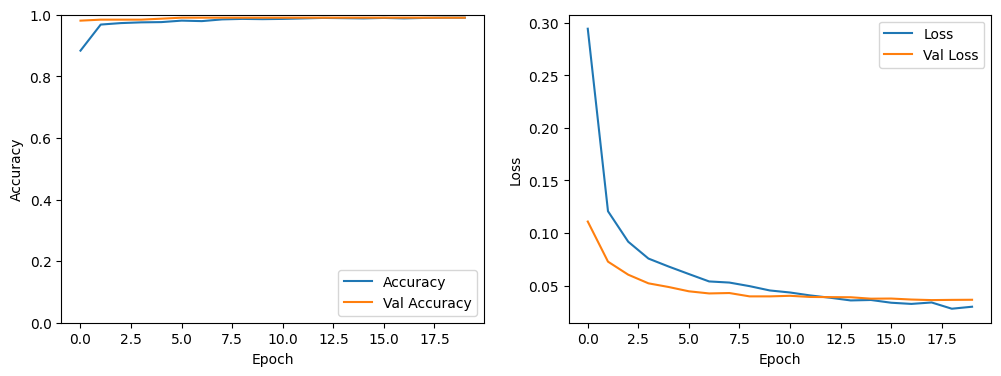

In [ ]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Accuracy')
plt.plot(history.history['val_accuracy'], label = 'Val Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend(loc='lower right')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Loss')
plt.plot(history.history['val_loss'], label = 'Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')

In [ ]:
y_true = []
y_pred = []

for images, labels in validation_dataset:
    predictions = model.predict(images)
    y_true.extend(labels.numpy())
    y_pred.extend((predictions > 0.5).astype(int).flatten())

# Calculate and print the evaluation metrics
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)
conf_matrix = confusion_matrix(y_true, y_pred)
class_report = classification_report(y_true, y_pred)

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)
print("Confusion Matrix:\n", conf_matrix)
print("Classification Report:\n", class_report)

1/1 [==============================] - 0s 159ms/step
Accuracy: 0.9903846153846154
Precision: 0.991869918699187
Recall: 0.9959183673469387
F1 Score: 0.9938900203665988
Confusion Matrix:
 [[ 65   2]
 [  1 244]]
Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.97      0.98        67
           1       0.99      1.00      0.99       245

    accuracy                           0.99       312
   macro avg       0.99      0.98      0.99       312
weighted avg       0.99      0.99      0.99       312



In [ ]:
def classify_image(img_path):
    img = tf.keras.preprocessing.image.load_img(img_path, target_size=(224, 224))
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)
    score = predictions[0]

    if score < 0.5:
        print("This image is a CongestedStreet.")
    else:
        print("This image is a NotCongestedStreet.")

    plt.imshow(img)
    plt.title("Congested_Street" if score < 0.5 else "Not_Congested_Street")
    plt.axis('off')
    plt.show()

1/1 [==============================] - 0s 57ms/step
This image is a NotCongestedStreet.


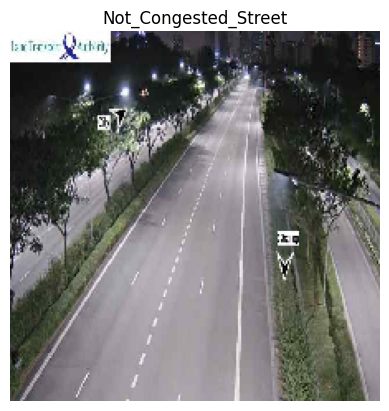

In [ ]:
classify_image('/content/drive/MyDrive/notcongestedtest.jpg')